In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from pyvis.network import Network

In [ ]:
# python versioin : python 3.7.13

# networkx=2.6.3
# powerlaw=1.4.6
# pyvis=0.2.1
# tqdm=4.64.0

In [3]:
Net_df = pd.read_csv('Net_df_0929_total_region.csv')

class ClusterNetwork:
    
    def __init__(self, data, PATH):
        self.Net_df = data
        self.PATH = PATH
        
        self.all_node ,self.all_edge, self.m_depth, self.m_degree = [],[],[],[]
        self.center_node, self.center_edge = [], []
        self.etc_node, self.etc_edge = [], []
        self.cluster_name = []
        self.mean_deg,self.med_deg = [],[]
        self.mean_depth,self.med_depth = [],[]
        self.center, self.etc = None, None
        self.center_m_depth_id = []
        self.center_m_deg_id = []
        self.etc_m_depth_id = []
        self.etc_m_deg_id = []
        
        self.Power_law_table = pd.DataFrame({'cluster_name' : [],
                                             'xmin' : [],
                                             'xmax' : [],
                                             'alpha' : [],
                                             'R1_power_law' : [],
                                             'exponential' : [],
                                             'R2_power_law' : [],
                                             'truncated_power_law' : [],
                                             'R3_power_law' : [],
                                             'lognormal' : []})

    def cluster_data(self, i):

        self.target_date = []
        if i == 0:
            self.Net_df_1 = self.Net_df[(self.Net_df['cluster_type'] == '신천지관련') | (self.Net_df['cluster_type'] == '신천지교인')]
            self.target_date.append('신천지관련')
        elif i == 1:
            self.Net_df_1 = self.Net_df[(self.Net_df['cluster_type'] == '수도권개척교회모임관련')]
            self.target_date.append('수도권개척교회모임관련')
        elif i == 2:    
            self.Net_df_1 = self.Net_df[(self.Net_df['cluster_type'] == '용산클럽')]
            self.target_date.append('용산클럽')
        elif i == 3:
            self.Net_df_1 = self.Net_df[(self.Net_df['cluster_type'] == '성북구사랑제일교회관련') | (self.Net_df['cluster_type'] == '815도심집회관련') | (self.Net_df['cluster_type'] == '성북구사랑제일교회')]
            self.target_date.append('성북구사랑제일교회관련')
        elif i == 4:
            self.Net_df_1 = self.Net_df[(self.Net_df['cluster_type'] == '경기남양주시플라스틱공장관련')]
            self.target_date.append('경기남양주시플라스틱공장관련')
        elif i == 5:
            self.Net_df_1 = self.Net_df[(self.Net_df['cluster_type'] == '인천남동구가족및지인관련')]
            self.target_date.append('인천남동구가족및지인관련')
        elif i == 6:
            self.Net_df_1 = self.Net_df[(self.Net_df['cluster_type'] == '서울용산구대학병원관련')]
            self.target_date.append('서울용산구대학병원관련')
        elif i == 7:
            self.Net_df_1 = self.Net_df[(self.Net_df['cluster_type'] == '광주광산구효정요양병원관련')]
            self.target_date.append('광주광산구효정요양병원관련')
        elif i == 8:
            self.Net_df_1 = self.Net_df[(self.Net_df['cluster_type'] == '서울송파구교정시설관련')]
            self.target_date.append('서울송파구교정시설관련')
        elif i == 9:
            self.Net_df_1 = self.Net_df[(self.Net_df['cluster_type'] == '충남아산시난방기공장관련')]
            self.target_date.append('충남아산시난방기공장관련')
        elif i == 10:
            self.Net_df_1 = self.Net_df[(self.Net_df['cluster_type'] == '경남진주시목욕탕2관련')]
            self.target_date.append('경남진주시목욕탕2관련')
        elif i == 11:
            self.Net_df_1 = self.Net_df[(self.Net_df['cluster_type'] == '구미,울산지인/대구유흥주점관련')]
            self.target_date.append('구미,울산지인/대구유흥주점관련')
            
    def time_interval_data(self, target_date):
        '''
        data의 string으로 표현된 date 형식을 datetime.date()로 변환
        '''
        self.Net_df['inf_time'] = pd.to_datetime(self.Net_df['inf_time'], format="%Y-%m-%d", errors='ignore')
        self.Net_df['inf_time'] = self.Net_df['inf_time'].dt.date
        
        self.target_date = target_date
        for i in range(len(target_date)):
            self.target_date[i] = datetime.strptime(self.target_date[i], "%Y-%m-%d").date()
        self.Net_df_1 = self.Net_df[(self.Net_df['inf_time'] >= self.target_date[0]) & (self.Net_df['inf_time'] < self.target_date[1])]
    
    def define_network(self, filters, threshold, center=True, etc=True):
        '''
        threshold : etc network에 대해서 degree가 몇 이상일지를 정의
        filters : Pyvis Library toggle visualize(nodes, 'layout', 'interaction',  'edges', 'physics', 'manipulation')
        center : max degree를 가지는 cluster network 1개
        etc : center network를 제외한 나머지 전부
        '''
        
        from tqdm import tqdm
        self.center = center
        self.etc = etc
        
        # self.target_date = target_date
        # for i in range(len(target_date)):
        #     self.target_date[i] = datetime.strptime(self.target_date[i], "%Y-%m-%d").date()
        # self.Net_df_1 = self.Net_df[(self.Net_df['inf_time'] >= self.target_date[0]) & (self.Net_df['inf_time'] < self.target_date[1])]
        
        ####################################
        ## DataFrame으로부터 Network 정의 ##
        ####################################
        
        edge_depth = {}
        G = nx.from_pandas_edgelist(self.Net_df_1, source='Primary_id', target='id',create_using=nx.DiGraph())
        
        #########################################
        ## 선행확진자가 없는 경우(id = 0) 제거 ##
        #########################################
        
        G.remove_node(0)
        
        #################################################
        ## degree가 0인 node인 경우 remove_list에 저장 ##
        #################################################
        
        remove_list = []
        for i_l in tqdm(range(len(G.degree)), desc = f"Remove degree 0"):
            if list(dict(G.degree).values())[i_l] == 0:
                remove_list.append(list(dict(G.degree).keys())[i_l])
        G.remove_nodes_from(remove_list)
        
        ###################################
        ## pyvis를 통해서 Network 시각화 ##
        ###################################
        
        nt = Network("1000px", "1000px", directed=True, heading= 'all')
        nt.from_nx(G)
        nt.show_buttons(filter_=filters)
        nt.show(f"{self.PATH}{self.target_date[0]} all.html")
        
        ##############################
        ## G의 node, edge 등을 저장 ##
        ##############################
        
        self.all_node.append(len(G.nodes()))
        self.all_edge.append(len(G.edges()))
        self.cluster_name.append(str(self.target_date[0]))
        
        ##################################
        ## 선행확진자 id가 0이 아니라면 ##
        ##################################
        
        for k in tqdm(list(self.Net_df_1['Primary_id']), desc = f"Calculating Depth"):
            if k != 0:
                depth_list = []
                value_list = list(dict(nx.bfs_successors(G, k)).values())

                ########################################
                ## Primary id와 id가 같은 경우가 있음 ##
                ########################################            
            
                if len(value_list[0]) == 0: 
                    edge_depth[k] = 0 

                ################################################################
                ## value_list의 마지막 값이 시작 노드에서 가장 먼 노드의 값임 ##
                ################################################################
                else:           
                    depth_list.append(nx.shortest_path_length(G, source=k, target=value_list[-1][0])) 
                    edge_depth[k] = np.max(depth_list) # depth_list로 분포 그리기.
                    edge_depth[value_list[-1][0]] = 0 # 마지막 값은 추가 감염이 안일어났으므로 0으로 줘야함.

        # Network
        for k in tqdm(list(self.Net_df_1['id']), desc = f"Calculating Not in edge depth"):
            if k not in list(edge_depth.keys()):
                edge_depth[k] = 0

        #########################################################################
        ## 해당 기간에서 가장 큰 Degree를 가지는 Cluster Network의 정보를 저장 ##
        #########################################################################
        
        if self.center == True:
            
            degrees = dict(G.out_degree)
            
            self.m_degree.append(max(np.array(list(degrees.values()))))
            self.m_depth.append(max(edge_depth.values()))

            ###############################
            ## depth의 갯수를 세고, sort ##
            ###############################
            
            edge_scatter = Counter(edge_depth.values()) # depth의 갯수를 세줌
            edge_scatter = dict(sorted(edge_scatter.items())) # key를 기준으로 sort 해줌
            
            number_of_count_A = list(edge_scatter.values()) # depth의 명수를 세줌
            number_of_depth_A = list(edge_scatter.keys()) # depth를 세줌

            plt.figure()
            fig, ax = plt.subplots(figsize=(9,9))
            bar_plot = ax.bar(number_of_depth_A, number_of_count_A)
            ax.set_xlabel('depth', fontsize=20)
            ax.set_ylabel('count', fontsize=20)

            for idx,rect in enumerate(bar_plot):
                height = rect.get_height()
                ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                        list(number_of_count_A)[idx],
                        ha='center', va='bottom', rotation=0, fontsize=15)
            plt.savefig(f"{self.PATH}{self.target_date[0]} depth_count.png")


            ##############################################
            ## 가장 큰 degree를 갖는 node의 위치를 저장 ##
            ##############################################
            
            tp = np.where(max(np.array(list(degrees.values()))) == np.array(list(degrees.values())))
            tp_1 = list(degrees.keys())[tp[0][0]]

            dod = dict(nx.bfs_successors(G, tp_1))
            key = list(dod.keys())
            val = list(dod.values())


            infector_ = sum([[key[i_q]] * len(val[i_q]) for i_q in range(len(val))],[])
            infectee_ = sum([val[i_q] for i_q in range(len(val))],[])
            Net_df_ex = pd.DataFrame({'infector' : infector_,
                                    'infectee' : infectee_})
            
            ##########################################
            ## 가장 큰 degree를 갖는 network를 그림 ##
            ##########################################
            
            G_1 = nx.from_pandas_edgelist(Net_df_ex, source='infector', target='infectee',create_using=nx.DiGraph())

            nt = Network("1000px", "1000px", directed=True, heading= 'center')#, bgcolor='#222222', font_color='white')
            nt.from_nx(G_1)
            nt.show_buttons(filter_=filters)
            nt.show(f"{self.PATH}{self.target_date[0]} center.html")
            
            ############################
            ## Node, Edgd 정보를 저장 ##
            ############################
            
            self.center_node.append(len(G_1.nodes()))
            self.center_edge.append(len(G_1.edges()))
            m_deg_loc = np.where(max(list(degrees.values())) == np.array(list(degrees.values())))
            m_depth_loc = np.where(max(list(edge_depth.values())) == np.array(list(edge_depth.values())))
            self.center_m_deg_id.append(list(degrees.keys())[m_deg_loc[0][0]])
            
            for i in tqdm(range(len(m_depth_loc[0])), desc = f"Calculating Center Depth ID"):
                tmp = []
                if len([list(edge_depth.keys())[m_depth_loc[0][i]]]) == 0:
                    tmp.append([])
                else:
                    tmp.append(list(edge_depth.keys())[m_depth_loc[0][i]])
            self.center_m_depth_id.append(tmp)
        
        #############################################################################    
        ## Degree가 threshold보다 큰 Cluster에 대해서 나머지 Network의 정보를 저장 ##
        #############################################################################
        
        if (self.etc == True) & (self.center == False):
            
            ##########################################
            ## center -> etc 순서대로 계산되어야 함 ##
            ##########################################
            
            raise Exception('etc and center must be True')   
        
        elif self.etc == True:
            
            ##################################################################
            ## threshold보다 크고, remove list에 있지 않은 cluster에 대해서 ##
            ##################################################################
            
            remove_list = list(G_1.nodes())
            tp = []
            for jj in tqdm(range(len(degrees)), desc=f"Calculating Not in remove list, upper than threshold"):
                if (list(degrees.keys())[jj] not in remove_list) & (list(degrees.values())[jj] >= threshold):
                    tp.append(list(degrees.keys())[jj])
                    
            Net_df_ex2 = pd.DataFrame()
            G.remove_nodes_from(remove_list)

            #############################################
            ## Etc Network를 정의하고, Node, Edge 정의 ##
            #############################################
            
            for kk in tqdm(range(len(tp)), desc = f"Calculating etc node, edge"):
                dod = dict(nx.bfs_successors(G, tp[kk]))
                key = list(dod.keys())
                val = list(dod.values())

                infector_2 = sum([[key[i_q]] * len(val[i_q]) for i_q in range(len(val))],[])
                infectee_2 = sum([val[i_q] for i_q in range(len(val))],[])
                
                data_insert = pd.DataFrame({'infector' : infector_2,'infectee' : infectee_2})
                Net_df_ex2 = Net_df_ex2.append(data_insert, ignore_index=True)
                Net_df_ex2 = Net_df_ex2.astype(int)
                
            if Net_df_ex2.empty == False:
                G_2 = nx.from_pandas_edgelist(Net_df_ex2, source='infector', target='infectee',create_using=nx.DiGraph())
                
                nt = Network("1000px", "1000px", directed=True, heading= 'etc')
                nt.from_nx(G_2)
                nt.show_buttons(filter_=filters)
                nt.show(f"{self.PATH}{self.target_date[i]} ect.html")
                self.etc_node.append(len(G_2.nodes()))
                self.etc_edge.append(len(G_2.edges()))
        
            ####################################################################
            ## max degree를 가지는 node id, max depth를 가지는 node id를 저장 ##
            ####################################################################
        
            m_deg_loc = np.where(max(list(degrees.values())) == np.array(list(degrees.values())))
            m_depth_loc = np.where(max(list(edge_depth.values())) == np.array(list(edge_depth.values())))
            self.etc_m_deg_id.append(list(degrees.keys())[m_deg_loc[0][0]])
            
            tmp = []
            for i in tqdm(range(len(m_depth_loc[0])), desc = f"Calculating Etc depth"):
                if len([list(edge_depth.keys())[m_depth_loc[0][i]]]) == 0:
                    tmp.append([])
                else:
                    tmp.append(list(edge_depth.keys())[m_depth_loc[0][i]])
            self.etc_m_depth_id.append(tmp)
            
            self.mean_deg.append(np.mean(list(degrees.values())))
            self.med_deg.append(np.median(list(degrees.values())))
            self.mean_depth.append(np.mean(list(edge_depth.values())))
            self.med_depth.append(np.median(list(edge_depth.values())))



    def power_law_fit(self):
        '''
        Only use Period Data
        Not use Cluster Data
        '''
        import powerlaw

        Net_time = self.Net_df[(self.Net_df['inf_time'] >= self.target_date[0]) & (self.Net_df['inf_time'] < self.target_date[1])]
        
        count_net = Net_time['Primary_id'].value_counts()

        # Counter(count_net)
        data = list(count_net)[1:] # primary_id가 0인 사람 제외

        plt.figure(figsize=(9,9))
        fit = powerlaw.Fit(data, discrete=True)#, xmin=xmin)
        # figCCDF = fit.plot_pdf(color='b', linewidth=2)
        # fit.power_law.plot_pdf(color='b', linestyle='dotted', ax=figCCDF)
        
        ###########################################
        ## Lognormal, Exponential, Power law fit ##
        ###########################################
        
        figCCDF = fit.plot_ccdf(color='r', linewidth=2, label='Data')
        fit.power_law.plot_ccdf(color='r', linestyle='--', ax=figCCDF, label='Power law fit')
        fit.lognormal.plot_ccdf(ax=figCCDF, color='g', linestyle='--', label='Lognormal fit')
        fit.exponential.plot_ccdf(ax=figCCDF, color='k', linestyle='--', label='Exponential fit')
        
        figCCDF.set_ylabel(u"p(X),  p(X≥x)", fontsize=20)
        figCCDF.set_xlabel(r"Secondary Infection", fontsize=20)
        plt.xticks(fontsize=15)
        
        xmin = fit.xmin
        xmax = fit.xmax
        alpha = fit.alpha
        
        Rp1, Pe = fit.distribution_compare('power_law', 'exponential',normalized_ratio=True)
        Rp2, Pt = fit.distribution_compare('power_law', 'truncated_power_law',normalized_ratio=True)
        Rp3, Pl = fit.distribution_compare('power_law', 'lognormal',normalized_ratio=True)
        
        data_to_insert = {'cluster_name' : [],
                          'xmin' : xmin,
                          'xmax' : xmax,
                          'alpha' : alpha,
                          'R1_power_law' : Rp1,
                          'exponential' : Pe,
                          'R2_power_law' : Rp2,
                          'truncated_power_law' : Pt,
                          'R3_power_law' : Rp3,
                          'lognormal' : Pl}
        
        self.Power_law_table = self.Power_law_table.append(data_to_insert, ignore_index=True)
        self.Power_law_table['cluster_name'] = self.cluster_name
        
        handles, labels = figCCDF.get_legend_handles_labels()
        figCCDF.legend(handles, labels, loc=3, fontsize=20)
        figname = 'FigCCDF+ex+log'
        plt.savefig(f"{self.PATH}{self.target_date[0]} {figname}.png", bbox_inches='tight')#, dpi=300, format='eps')
        self.Power_law_table.to_csv(f"{self.PATH}Power_law_Parameter.csv", encoding='utf-8-sig')



    def save_information_table(self):
        '''
        dataframe을 정의하고 정보들을 csv 파일로 저장
        '''
        data_to_insert =pd.DataFrame({'cluster_name' : self.cluster_name,
                                      'all_node' : self.all_node,
                                      'all_edge' : self.all_edge})
        
        if self.center == True:
            data_to_insert_2 = pd.DataFrame({'m_depth' : self.m_depth,
                                             'center_m_depth_id' : self.center_m_depth_id,
                                             'm_degree' : self.m_degree,
                                             'center_m_deg_id' : self.center_m_deg_id,
                                             'center_node' : self.center_node,
                                             'center_edge' : self.center_edge})
            data_to_insert = pd.concat([data_to_insert, data_to_insert_2], axis=1)
            
        if self.etc == True:
            data_to_insert_2 = pd.DataFrame({'etc_node' : self.etc_node,
                                             'etc_edge' : self.etc_edge,
                                             'etc_m_deg_id' : self.etc_m_deg_id,
                                             'etc_m_depth_id' : self.etc_m_depth_id,
                                             'mean_deg': self.mean_deg,
                                             'med_deg': self.med_deg,
                                             'mean_depth': self.mean_depth,
                                             'med_depth': self.med_depth})
            data_to_insert = pd.concat([data_to_insert, data_to_insert_2], axis=1)
        # return data_to_insert
        data_to_insert.to_csv(f"{self.PATH}tabel per period.csv", encoding='utf-8-sig')

In [4]:
# Cluster
data = pd.read_csv('Net_df_0929_total_region.csv')
filters = []#['nodes, 'layout', 'interaction',  'edges', 'physics', 'manipulation']
PATH = '/Users/jeonjunhwi/문서/Projects/Infection_tree/Results/'
threshold = 2
net = ClusterNetwork(data, PATH)

for i in range(3):
    net.cluster_data(i)
    net.define_network(filters = filters, threshold = threshold, center=False, etc=False)
    # net.save_information_table()#center=True, etc=True)

Calculating Not in edge depth: 100%|██████████| 277/277 [00:00<00:00, 278080.95it/s]


Period : 2020-01-19 ~ 2020-04-30


Calculating Center Depth ID: 100%|██████████| 1/1 [00:00<00:00, 2746.76it/s]
Calculating Not in remove list, upper than threshold: 100%|██████████| 2074/2074 [00:00<00:00, 31390.91it/s]
Calculating Etc depth: 100%|██████████| 1/1 [00:00<00:00, 2695.57it/s]
Calculating best minimal value for power law fit
/opt/anaconda3/envs/cluster_venv/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/anaconda3/envs/cluster_venv/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/anaconda3/envs/cluster_venv/lib/python3.7/site-packages/powerlaw.py:1560: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm
/opt/anaconda3/envs/cluster_venv/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_

Period : 2020-04-30 ~ 2020-07-15


Calculating Center Depth ID: 100%|██████████| 1/1 [00:00<00:00, 8144.28it/s]
Calculating Not in remove list, upper than threshold: 100%|██████████| 1342/1342 [00:00<00:00, 47759.60it/s]
Calculating Etc depth: 100%|██████████| 1/1 [00:00<00:00, 11397.57it/s]
Calculating best minimal value for power law fit
/opt/anaconda3/envs/cluster_venv/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/anaconda3/envs/cluster_venv/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/anaconda3/envs/cluster_venv/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Assuming nested distributions
/opt/anaconda3/envs/cluster_venv/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in tru

<Figure size 432x288 with 0 Axes>

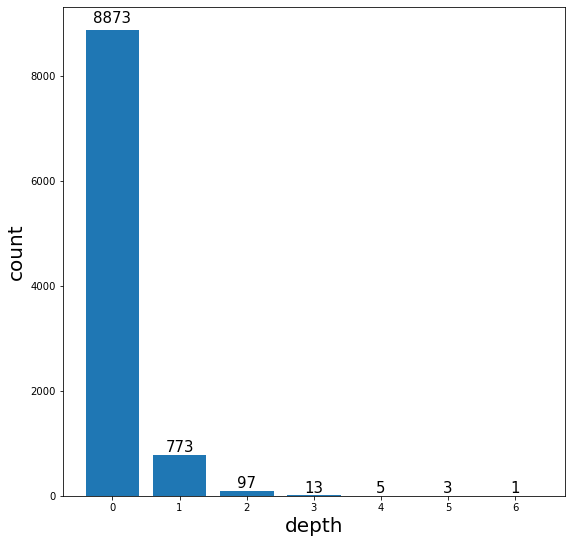

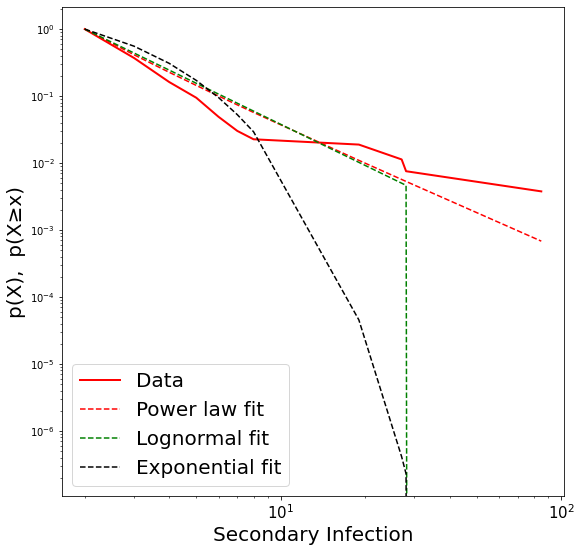

<Figure size 432x288 with 0 Axes>

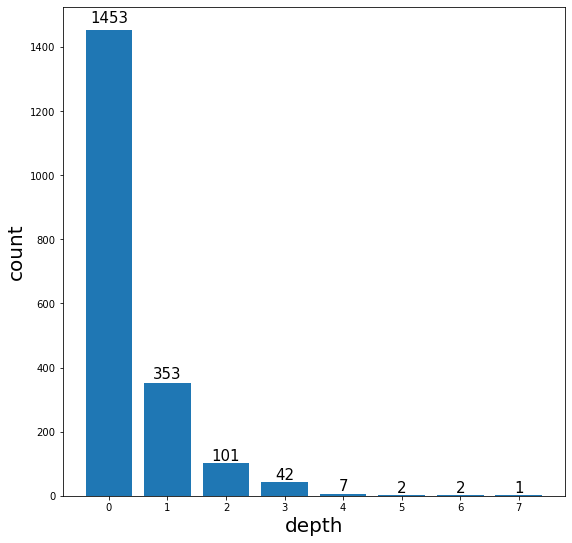

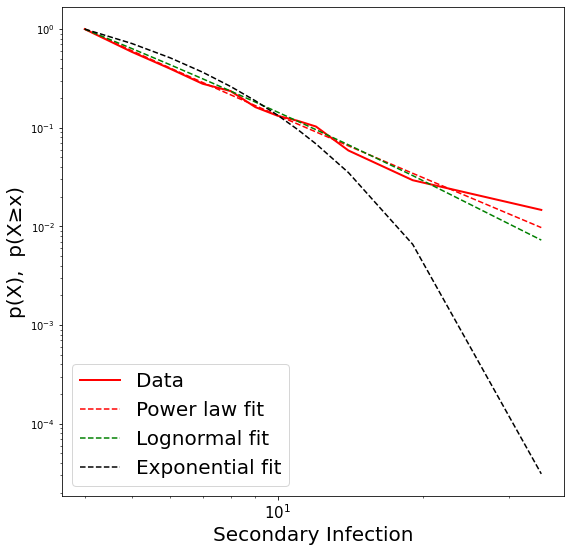

In [5]:
# Period
target_date = ['2020-01-19', '2020-04-30', '2020-07-15']#, '2020-10-13', '2021-02-26', '2021-07-11']
data = pd.read_csv('Net_df_0929_total_region.csv')
filters = []#['edges', 'physics', 'manipulation']
PATH = '/Users/jeonjunhwi/문서/Projects/Infection_tree/Results/'
threshold = 2
net = ClusterNetwork(data, PATH)

for i in range(len(target_date)-1):
    print(f"Period : {target_date[i]} ~ {target_date[i+1]}")
    net.time_interval_data([target_date[i], target_date[i+1]])
    net.define_network(filters = filters, threshold = threshold, center=True, etc=True)
    net.power_law_fit()
    net.save_information_table()#center=True, etc=True)